In [1]:
!pip install kmodes

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from kmodes.kmodes import KModes
import tqdm

In [3]:
!gdown --id 1ZTjQU7riYALEWAPX5AAMrFjENQ1Bow3C

Downloading...
From: https://drive.google.com/uc?id=1ZTjQU7riYALEWAPX5AAMrFjENQ1Bow3C
To: /content/bank.csv
100% 6.42M/6.42M [00:00<00:00, 24.3MB/s]


#DATA PREPROCESSING

In [4]:
bank = pd.read_csv('bank.csv', sep=';')
bank = bank.drop('duration', axis=1)
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
bank.shape

(45307, 20)

In [6]:
#check if there exists any missing value in the table
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
#check duplicate
data_dup = bank[bank.duplicated(keep="last")]
data_dup

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
14,35,blue-collar,married,basic.6y,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
16,35,blue-collar,married,basic.6y,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44034,58,retired,married,basic.4y,no,no,no,cellular,jul,tue,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
44272,28,student,single,basic.9y,no,yes,no,cellular,mar,tue,1,999,0,nonexistent,-1.8,92.843,-50.0,1.799,5099.1,yes
44666,33,technician,single,professional.course,no,yes,no,cellular,aug,wed,1,999,0,nonexistent,1.4,93.444,-36.1,4.967,5228.1,no
44704,31,admin.,married,university.degree,no,no,no,cellular,aug,wed,1,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no


In [8]:
bank = bank.drop_duplicates()
bank.shape

(39404, 20)

In [9]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

no     34806
yes     4598
Name: y, dtype: int64

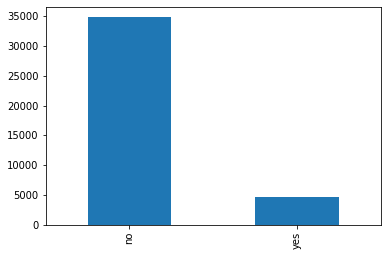

In [10]:
bank.y.value_counts().plot(kind = 'bar')
bank.y.value_counts()

In [87]:
for col in bank:
    print(bank[col].nunique())

78
12
4
8
3
3
3
2
10
5
42
27
8
3
10
26
26
316
11
2


In [11]:
bank.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,39404.000000,39404.000000,39404.000000,39404.000000,39404.000000,39404.000000,39404.000000,39404.000000,39404.000000
mean,40.116105,2.618744,960.847097,0.178738,0.064067,93.577538,-40.499604,3.601243,5165.986481
std,10.460328,2.814780,190.869184,0.503172,1.577041,0.583820,4.644327,1.742337,72.763866
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.798000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [12]:
bank_categories = bank[['age','job', 'marital', 'education', 'default', 'housing', 'loan','contact','month','day_of_week','poutcome']]

In [13]:
bank_categories.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,37,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,56,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


In [14]:
bank_categories.shape

(39404, 11)

In [15]:
bank_copy = bank.copy()

scaler = StandardScaler()
num_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

bank_copy[num_cols] = scaler.fit_transform(bank_copy[num_cols])

bank_copy.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,1.518508,housemaid,married,basic.4y,no,no,no,telephone,may,mon,-0.575095,0.199893,-0.355227,nonexistent,0.656892,0.713348,0.882723,0.720741,0.343767,no
1,1.614109,services,married,high.school,unknown,no,no,telephone,may,mon,-0.575095,0.199893,-0.355227,nonexistent,0.656892,0.713348,0.882723,0.720741,0.343767,no
2,-0.297901,services,married,high.school,no,yes,no,telephone,may,mon,-0.575095,0.199893,-0.355227,nonexistent,0.656892,0.713348,0.882723,0.720741,0.343767,no
3,-0.011100,admin.,married,basic.6y,no,no,no,telephone,may,mon,-0.575095,0.199893,-0.355227,nonexistent,0.656892,0.713348,0.882723,0.720741,0.343767,no
4,1.518508,services,married,high.school,no,no,yes,telephone,may,mon,-0.575095,0.199893,-0.355227,nonexistent,0.656892,0.713348,0.882723,0.720741,0.343767,no


In [16]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan','contact','month','day_of_week','poutcome']
encoder = OneHotEncoder(sparse=False)

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(bank_copy[cat_cols]))
print(df_encoded.shape)
df_encoded.columns = encoder.get_feature_names(cat_cols)

# Replace Categotical Data with Encoded Data
bank_copy = bank_copy.drop(cat_cols ,axis=1)
print(bank_copy.shape)
bank_copy.reset_index(drop=True, inplace=True)
df_encoded.reset_index(drop=True, inplace=True)
bank_copy = pd.concat([bank_copy, df_encoded], axis=1)
print(bank_copy.shape)

# Encode target value
bank_copy['y'] = bank_copy['y'].apply(lambda x: 1 if x == 'yes' else 0)

print('Shape of dataframe:', bank_copy.shape)
bank_copy.head()

(39404, 53)
(39404, 10)
(39404, 63)
Shape of dataframe: (39404, 63)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.518508,-0.575095,0.199893,-0.355227,0.656892,0.713348,0.882723,0.720741,0.343767,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.614109,-0.575095,0.199893,-0.355227,0.656892,0.713348,0.882723,0.720741,0.343767,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.297901,-0.575095,0.199893,-0.355227,0.656892,0.713348,0.882723,0.720741,0.343767,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.011100,-0.575095,0.199893,-0.355227,0.656892,0.713348,0.882723,0.720741,0.343767,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.518508,-0.575095,0.199893,-0.355227,0.656892,0.713348,0.882723,0.720741,0.343767,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
X = bank_copy.drop(columns='y')
y = bank_copy['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (31523, 62)
Number transactions y_train dataset:  (31523,)
Number transactions X_test dataset:  (7881, 62)
Number transactions y_test dataset:  (7881,)


#Classification Model

In [89]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    print('Accuracy of the model on Testing Sample Data:', round(f1,2))
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

In [90]:
from sklearn.ensemble import RandomForestClassifier

# Building Random Forest model 
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [101]:
# Evaluate Model
rf_eval = evaluate_model(rf, X_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Cohens Kappa Score:', rf_eval['kappa'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy_Values_rf=cross_val_score(rf, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values_rf)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values_rf.mean(),2))

Accuracy of the model on Testing Sample Data: 0.38
Accuracy: 0.8865626189569852
Precision: 0.5222437137330754
Recall: 0.29443838604143946
F1 Score: 0.37656903765690375
Cohens Kappa Score: 0.31947317422209376
Area Under Curve: 0.7552391266629376
Confusion Matrix:
 [[6717  247]
 [ 647  270]]

Accuracy values for 10-fold Cross Validation:
 [0.82869557 0.44528802 0.57255711 0.20634676 0.052403  ]

Final Average Accuracy of the model: 0.42


In [78]:
from sklearn.neighbors import KNeighborsClassifier

# Building KNN model 
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [92]:
# Evaluate Model
knn_eval = evaluate_model(knn, X_test, y_test)

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Cohens Kappa Score:', knn_eval['kappa'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy_Values_Knn=cross_val_score(knn, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values_Knn)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values_Knn.mean(),2))

Accuracy of the model on Testing Sample Data: 0.38
Accuracy: 0.8818677832762339
Precision: 0.4882154882154882
Recall: 0.31624863685932386
F1 Score: 0.3838517538054268
Cohens Kappa Score: 0.32180885209489596
Area Under Curve: 0.7089161457866817
Confusion Matrix:
 [[6660  304]
 [ 627  290]]

Accuracy values for 10-fold Cross Validation:
 [0.82853462 0.8261585  0.76590927 0.81266017 0.79980778 0.72363724
 0.63966294 0.61459318 0.73673276 0.32844361]

Final Average Accuracy of the model: 0.71


In [98]:
from sklearn.linear_model import LogisticRegression

# Building LgR model 
LgR = LogisticRegression(C=1,penalty='l2', solver='lbfgs', max_iter=1000)
LgR.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000)

In [99]:
# Evaluate Model
lgr_eval = evaluate_model(LgR, X_test, y_test)

# Print result
print('Accuracy:', lgr_eval['acc'])
print('Precision:', lgr_eval['prec'])
print('Recall:', lgr_eval['rec'])
print('F1 Score:', lgr_eval['f1'])
print('Cohens Kappa Score:', lgr_eval['kappa'])
print('Area Under Curve:', lgr_eval['auc'])
print('Confusion Matrix:\n', lgr_eval['cm'])

Accuracy_Values_lgr=cross_val_score(LgR, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values_lgr)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values_lgr.mean(),2))

Accuracy of the model on Testing Sample Data: 0.35
Accuracy: 0.8956985154168253
Precision: 0.6384839650145773
Recall: 0.23882224645583425
F1 Score: 0.3476190476190476
Cohens Kappa Score: 0.30349603343641196
Area Under Curve: 0.7865672469162172
Confusion Matrix:
 [[6840  124]
 [ 698  219]]

Accuracy values for 10-fold Cross Validation:
 [0.82853462 0.82853462 0.82853462 0.82853462 0.8313165  0.8349429
 0.85837059 0.47717298 0.88175152 0.34719436]

Final Average Accuracy of the model: 0.75


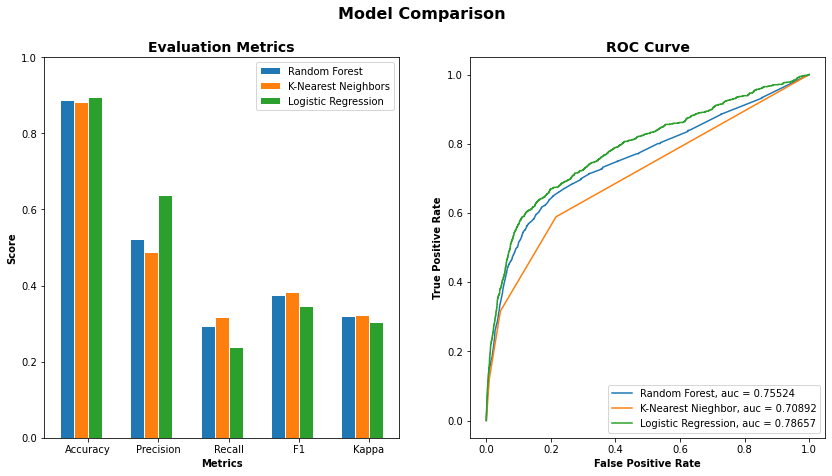

In [100]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
#dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1'], dtc_eval['kappa']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['kappa']]
lgr_score = [lgr_eval['acc'], lgr_eval['prec'], lgr_eval['rec'], lgr_eval['f1'], lgr_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
#r4 = [x + barWidth for x in r3]

## Make the plot
#ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r2, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')
ax1.bar(r3, lgr_score, width=barWidth, edgecolor='white', label='Logistic Regression')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
#ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))
ax2.plot(lgr_eval['fpr'], lgr_eval['tpr'], label='Logistic Regression, auc = {:0.5f}'.format(lgr_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

In [30]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500]
}

# Create a base model
rf_grids = RandomForestClassifier(random_state=0)

# Initiate the grid search model
#grid_search = RandomizedSearchCV(estimator=rf_grids, param_grid=param_grid, scoring='recall',
#                           cv=5, n_jobs=-1, verbose=2)

grid_search = RandomizedSearchCV(estimator=rf_grids, param_distributions=param_grid,
                           cv=5, n_iter=150, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 150 candidates, totalling 750 fits


{'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

In [104]:
# Select best model with best fit
best_grid = grid_search.best_estimator_

# Evaluate Model
best_grid_eval = evaluate_model(best_grid, X_test, y_test)

# Print result
print('Accuracy:', best_grid_eval['acc'])
print('Precision:', best_grid_eval['prec'])
print('Recall:', best_grid_eval['rec'])
print('F1 Score:', best_grid_eval['f1'])
print('Cohens Kappa Score:', best_grid_eval['kappa'])
print('Area Under Curve:', best_grid_eval['auc'])
print('Confusion Matrix:\n', best_grid_eval['cm'])
Accuracy_Values_best=cross_val_score(best_grid, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values_best)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values_best.mean(),2))

Accuracy of the model on Testing Sample Data: 0.33
Accuracy: 0.8967136150234741
Precision: 0.6688524590163935
Recall: 0.22246455834242093
F1 Score: 0.3338788870703764
Cohens Kappa Score: 0.29280299038320345
Area Under Curve: 0.7892818621018393
Confusion Matrix:
 [[6863  101]
 [ 713  204]]

Accuracy values for 10-fold Cross Validation:
 [0.82853462 0.82853462 0.82612716 0.82853462 0.8294748  0.82944746
 0.33909795 0.43265308 0.7479336  0.22132525]

Final Average Accuracy of the model: 0.67


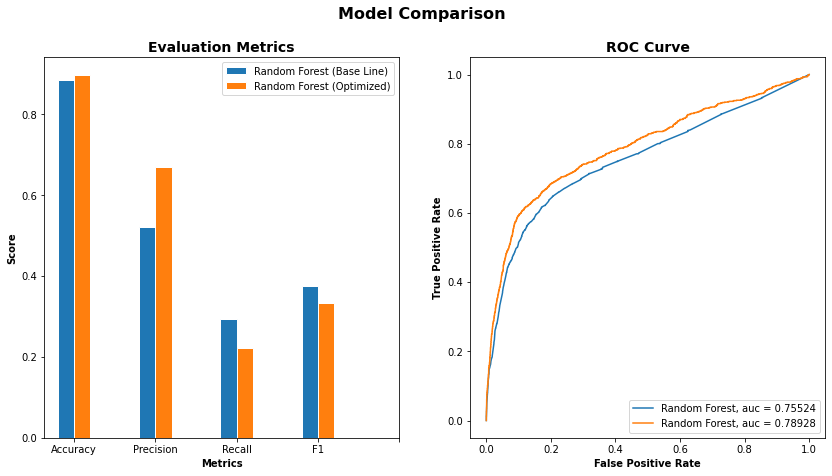

Change of 1.14% on accuracy.
Change of 28.07% on precision.
Change of -24.44% on recall.
Change of -11.34% on F1 score.
Change of -8.35% on Kappa score.
Change of 4.51% on AUC.


In [107]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1']]
best_grid_score = [best_grid_eval['acc'], best_grid_eval['prec'], best_grid_eval['rec'], best_grid_eval['f1']]

## Set position of bar on X axis
r1 = np.arange(len(rf_score))
r2 = [x + barWidth for x in r1]

## Make the plot
ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Random Forest (Base Line)')
ax1.bar(r2, best_grid_score, width=barWidth, edgecolor='white', label='Random Forest (Optimized)')

## Add xticks on the middle of the group bars
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
ax1.set_xticks([r + (barWidth * 0.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
# ax1.set_ylim(0, 1)

## Create legend & Show graphic
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(best_grid_eval['fpr'], best_grid_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(best_grid_eval['auc']))

ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.legend(loc=4)

plt.show()

print('Change of {:0.2f}% on accuracy.'.format(100 * ((best_grid_eval['acc'] - rf_eval['acc']) / rf_eval['acc'])))
print('Change of {:0.2f}% on precision.'.format(100 * ((best_grid_eval['prec'] - rf_eval['prec']) / rf_eval['prec'])))
print('Change of {:0.2f}% on recall.'.format(100 * ((best_grid_eval['rec'] - rf_eval['rec']) / rf_eval['rec'])))
print('Change of {:0.2f}% on F1 score.'.format(100 * ((best_grid_eval['f1'] - rf_eval['f1']) / rf_eval['f1'])))
print('Change of {:0.2f}% on Kappa score.'.format(100 * ((best_grid_eval['kappa'] - rf_eval['kappa']) / rf_eval['kappa'])))
print('Change of {:0.2f}% on AUC.'.format(100 * ((best_grid_eval['auc'] - rf_eval['auc']) / rf_eval['auc'])))

#Clustering

In [33]:
bank_copy_2 = bank.copy()

bank_copy_2['y_prediction_dtc'] = dtc.predict(X)
bank_copy_2['y_prediction_knn'] = knn.predict(X)
bank_copy_2['y_prediction_rf'] = rf.predict(X)
bank_copy_2['y_prediction_lgr'] = LgR.predict(X)
bank_copy_2['y_prediction_dtc'] = bank_copy_2['y_prediction_dtc'].apply(lambda x: 'yes' if x==0 else 'no')
bank_copy_2['y_prediction_knn'] = bank_copy_2['y_prediction_knn'].apply(lambda x: 'yes' if x==0 else 'no')
bank_copy_2['y_prediction_rf'] = bank_copy_2['y_prediction_rf'].apply(lambda x: 'yes' if x==0 else 'no')
bank_copy_2['y_prediction_lgr'] = bank_copy_2['y_prediction_lgr'].apply(lambda x: 'yes' if x==0 else 'no')

# Save new dataframe into csv file
bank_copy_2.to_csv('y_prediction.csv', index=False)

bank_copy_2

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_prediction_dtc,y_prediction_knn,y_prediction_rf,y_prediction_lgr
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,yes,yes,yes,yes
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,yes,yes,yes,yes
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,yes,yes,yes,yes
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,yes,yes,yes,yes
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,yes,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,no,yes,no,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,yes,yes,yes,yes
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,yes,yes,yes,yes
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,no,yes,no,yes


In [34]:
bank_categories = bank_categories.drop('age', axis = 1)
bank_categories

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent
...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,nonexistent
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,nonexistent


In [35]:
bank_cat_copy = bank_categories.copy()

In [36]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
bank_categories = bank_categories.apply(le.fit_transform)
bank_categories.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,3,1,0,0,0,0,1,6,1,1
1,7,1,3,1,0,0,1,6,1,1
2,7,1,3,0,2,0,1,6,1,1
3,0,1,1,0,0,0,1,6,1,1
4,7,1,3,0,0,2,1,6,1,1


In [41]:
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 1, verbose=1)
    kmode.fit_predict(bank_categories)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 184750.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6598, cost: 163459.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 19724, cost: 154735.0
Run 1, iteration: 2/100, moves: 1501, cost: 154735.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10095, cost: 152717.0
Run 1, iteration: 2/100, moves: 839, cost: 152717.0


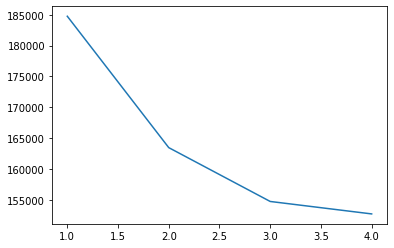

In [42]:
re = np.array([i for i in range(1,5)])
plt.plot(re, cost)

In [43]:
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=1)
fitClusters_huang = km_huang.fit_predict(bank_categories)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6051, cost: 165734.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 10717, cost: 168209.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 6500, cost: 170040.0
Run 3, iteration: 2/100, moves: 2118, cost: 170040.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 8144, cost: 163943.0
Run 4, iteration: 2/100, moves: 3318, cost: 163943.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 10224, cost: 165546.0
Best run was number 4


In [44]:
clustersDf = pd.DataFrame(fitClusters_huang)
clustersDf.columns = ['cluster_predicted']
bank_cat_copy.reset_index(drop=True, inplace=True)
clustersDf.reset_index(drop=True, inplace=True)
combinedDf = pd.concat([bank_cat_copy, clustersDf], axis = 1)

In [45]:
combinedDf.head(10)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,cluster_predicted
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,0
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,0
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,1
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,0
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,0
5,services,married,basic.9y,unknown,no,no,telephone,may,mon,nonexistent,0
6,admin.,married,professional.course,no,no,no,telephone,may,mon,nonexistent,0
7,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,nonexistent,0
8,technician,single,professional.course,no,yes,no,telephone,may,mon,nonexistent,1
9,services,single,high.school,no,yes,no,telephone,may,mon,nonexistent,1


In [47]:
combinedDf['cluster_predicted'].unique()

array([0, 1], dtype=uint16)

In [48]:
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]

In [49]:
cluster_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26418 entries, 0 to 39403
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   job                26418 non-null  object
 1   marital            26418 non-null  object
 2   education          26418 non-null  object
 3   default            26418 non-null  object
 4   housing            26418 non-null  object
 5   loan               26418 non-null  object
 6   contact            26418 non-null  object
 7   month              26418 non-null  object
 8   day_of_week        26418 non-null  object
 9   poutcome           26418 non-null  object
 10  cluster_predicted  26418 non-null  uint16
dtypes: object(10), uint16(1)
memory usage: 2.3+ MB


In [50]:
cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12986 entries, 2 to 39393
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   job                12986 non-null  object
 1   marital            12986 non-null  object
 2   education          12986 non-null  object
 3   default            12986 non-null  object
 4   housing            12986 non-null  object
 5   loan               12986 non-null  object
 6   contact            12986 non-null  object
 7   month              12986 non-null  object
 8   day_of_week        12986 non-null  object
 9   poutcome           12986 non-null  object
 10  cluster_predicted  12986 non-null  uint16
dtypes: object(10), uint16(1)
memory usage: 1.1+ MB


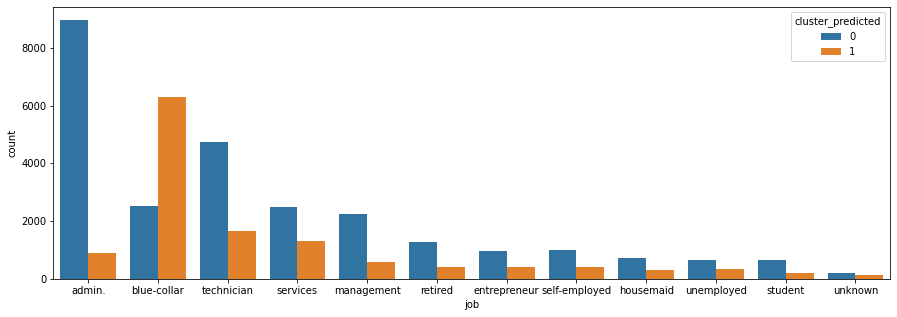

In [51]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['job'],order=combinedDf['job'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

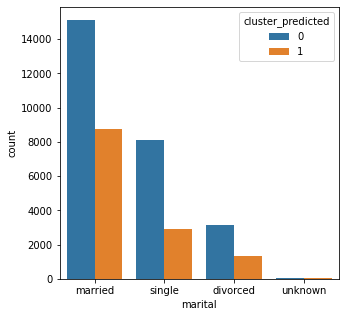

In [52]:
plt.subplots(figsize = (5,5))
sns.countplot(x=combinedDf['marital'],order=combinedDf['marital'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

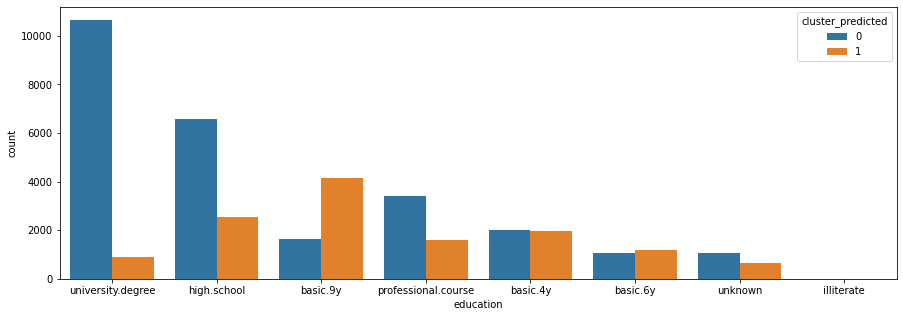

In [53]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['education'],order=combinedDf['education'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

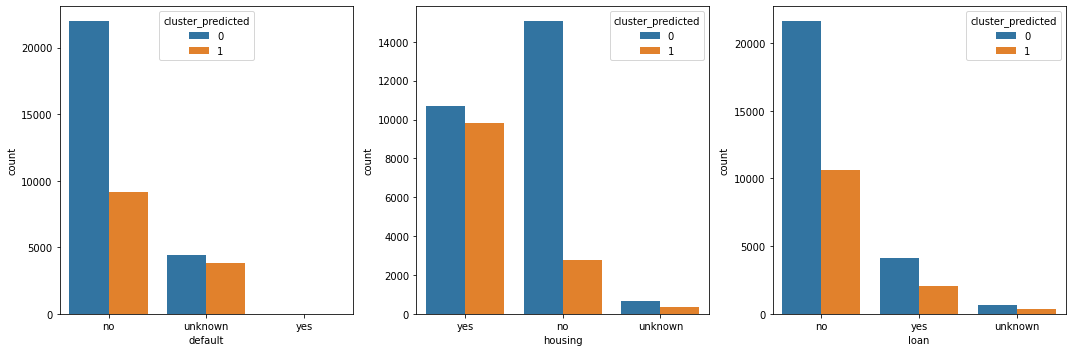

In [54]:
f, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=combinedDf['default'],order=combinedDf['default'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['housing'],order=combinedDf['housing'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[1])
sns.countplot(x=combinedDf['loan'],order=combinedDf['loan'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[2])

plt.tight_layout()
plt.show()

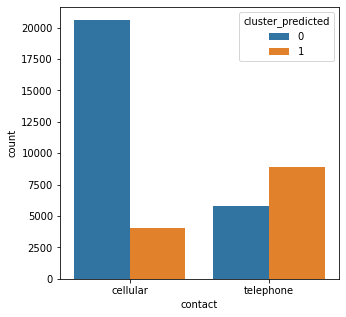

In [55]:
plt.subplots(figsize = (5,5))
sns.countplot(x=combinedDf['contact'],order=combinedDf['contact'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

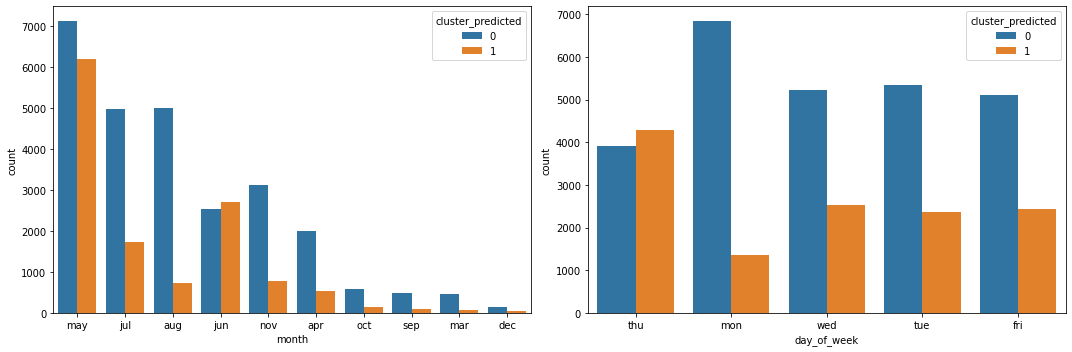

In [56]:
f, axs = plt.subplots(1,2,figsize = (15,5))
sns.countplot(x=combinedDf['month'],order=combinedDf['month'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['day_of_week'],order=combinedDf['day_of_week'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[1])

plt.tight_layout()
plt.show()

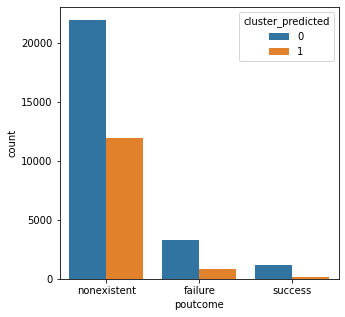

In [57]:
plt.subplots(figsize = (5,5))
sns.countplot(x=combinedDf['poutcome'],order=combinedDf['poutcome'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

#Frequent Pattern Mining

In [58]:
bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [59]:
bank_copy_3 = bank.copy()

In [63]:
n1, n2 = bank_copy_3.shape
n1

39404

In [61]:
bank_copy_3.values

array([[56, 'housemaid', 'married', ..., 4.857, 5191.0, 'no'],
       [57, 'services', 'married', ..., 4.857, 5191.0, 'no'],
       [37, 'services', 'married', ..., 4.857, 5191.0, 'no'],
       ...,
       [56, 'retired', 'married', ..., 1.028, 4963.6, 'no'],
       [44, 'technician', 'married', ..., 1.028, 4963.6, 'yes'],
       [74, 'retired', 'married', ..., 1.028, 4963.6, 'no']], dtype=object)

In [74]:
records = []
for i in tqdm.tqdm(range(0, 100)):
    records.append([str(bank_copy_3.values[i,j]) for j in range(0, n2)])

100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


In [68]:
!pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=53b9ce3c37b4e237f79d454ddee13bcdaeb63c6620727feaf255ba01ee5164c3
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori


In [69]:
from apyori import apriori

In [ ]:
association_rules = apriori(records, min_support=0.02, min_confidence=0.2, min_lift=3, min_length=2)

association_results = list(association_rules)

In [ ]:
print(len(association_rules))

In [ ]:
print(association_rules[0])

In [ ]:
for item in association_rules:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")